# Training an Autoencoder with ResNet to do image similarity search

This notebook shows and example of how the use a Convolutional Neural Network (CNN) to create a vector representation (embedding) of an image with reduced dimensionality and then use it to find other images that are similar by measuring the cosine distance between the embeddings. The images whose embeddings are closer to each other, should be more similar.

The CNN should make a good feature extraction to output embeddings that represent as accurate as possible the images. To tune the model that will generate the embeddings, we will build an Autoencoder. An Autoencoder has en encoder-decoder architecture. In this case, the encoder is the network that will reduce the dimensionality of the images and output an embedding. Then, the resulting embedding is fed to the decoder, which will try to rebuild the original image from the embedding the encoder generated.

Used **EuroSAT** data downloaded from **PyTorch** and decoder was based on code from [ResNet-decoder](https://github.com/JiahongChen/ResNet-decoder)

In [1]:
import os
from os import path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, Subset
from torchvision.models.resnet import ResNet50_Weights
import torchvision.transforms.v2.functional as F


class AutoEncoderDataset(Dataset):
    def __init__(self, images_dir: str):
        self.image_paths: list[str] = self.__get_image_paths(images_dir)

    def get_original_image(self, index: int) -> Tensor:
        rgb_im = self.__open_as_rgb_image(index)
        image = F.pil_to_tensor(rgb_im)
        image = image.float()
        image = image / 255
        return image

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, index: int):
        rgb_im = self.__open_as_rgb_image(index)
        resnet_preprocess = ResNet50_Weights.DEFAULT.transforms()
        image = resnet_preprocess(rgb_im)
        label = image.clone()
        return image, label

    def __get_image_paths(self, images_dir: str) -> list[str]:
        """Returns a list containing the absolute path to each file inside the directory
        """
        file_paths = []
        dir_abs_route = path.abspath(images_dir)
        files = os.listdir(dir_abs_route)
        for file in files:
            abs_filename = path.join(dir_abs_route, file)
            file_paths.append(abs_filename)
        return sorted(file_paths)

    def __open_as_rgb_image(self, index: int) -> Image.Image:
        img_path = self.image_paths[index]
        with Image.open(img_path) as im:
            rgb_im = im.convert('RGB')
        return rgb_im


def imshow(img):
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def map_subset_indices_to_original_dataset_indices(subset: Subset, indices: list[int]) -> list[int]:
    indices_map = [subset.indices[i] for i in indices]
    return list(indices_map)


def plot_images(dataset: AutoEncoderDataset, indices: list[int]):
    n = len(indices)
    _, axes = plt.subplots(ncols=n, nrows=1)
    for i in range(n):
        img = dataset.get_original_image(indices[i])
        npimg = np.array(img)
        npimg = np.transpose(npimg, (1, 2, 0))
        image_name = path.basename(path.splitext(dataset.image_paths[indices[i]])[0])
        axes[i].set_title(image_name)
        axes[i].imshow(npimg)
        axes[i].set_axis_off()
    plt.tight_layout()
    plt.show()


def print_loss_history(train_loss: list[float], val_loss: list[float]):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 8), )
    plt.plot(epochs, train_loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b--", label="Validation loss")
    plt.title("Training loss")
    plt.legend()
    plt.show()

For the decoder, we are only using the four blocks of ResNet-50, arranged in a way that they do the ooposite operations the encoder does. To be able to calculate the loss of the output, the output of the decoder should give a tensor with the same shape of the input image (N, C, W, H), hence the final layer is an `nn.ConvTranspose2d` layer that will transform the output of the decoder to a tensor of the shape (N, C, W, H). The parameters of that layer were selected manually so that the output will match the desired shape: (N, 3, 64, 64)

Finally, as the values of each channel must be between 0 and 1, a sigmoid activation function is used to clip the values of the tensor within that range.

In [2]:
from typing import Callable

import torch
from torch import Tensor
from torch.nn import BatchNorm2d, ConvTranspose2d, Identity, Module, ReLU, Sequential, Sigmoid, Upsample
from torchvision import models
from torchvision.models.resnet import ResNet


class DecoderBottleneck(Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        output_padding: int = 0,
        upsample: Module | None = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Callable[..., Module] | None = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.upsample layers upsample the input when stride != 1
        self.conv3 = conv1x1(planes * self.expansion, width)
        self.bn3 = norm_layer(planes)
        self.conv2 = conv3x3(width, width, stride, groups, dilation, output_padding)
        self.bn2 = norm_layer(width)
        self.conv1 = conv1x1(width, inplanes)
        self.bn1 = norm_layer(inplanes)
        self.relu = ReLU(inplace=True)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv3(x)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv1(out)
        out = self.bn1(out)
        if self.upsample is not None:
            identity = self.upsample(x)
        out += identity
        out = self.relu(out)

        return out


class ResNetDecoder(Module):
    def __init__(self, block, layers: list[int]):
        super().__init__()
        self._norm_layer = BatchNorm2d
        self.inplanes = 2048
        self.dilation = 1

        self.unsample = Upsample(size=7, mode="nearest")
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer1 = self._make_layer(block, 64, layers[0], output_padding = 0, last_block_dim=64)
        self.image_output = Sequential(
            ConvTranspose2d(64, 3, kernel_size=6, stride=4, padding=1, dilation=1),
            Sigmoid()
        )

    def forward(self, x):
        x = torch.unflatten(x, 1, (2048, 1, 1))
        x = self.unsample(x)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        x = self.image_output(x)
        return x

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        output_padding: int = 1,
        last_block_dim: int = 0,
    ) -> Sequential:
        norm_layer = self._norm_layer
        upsample = None
        previous_dilation = self.dilation
        self.groups = 1
        self.base_width = 64
        layers = []
        self.inplanes = planes * block.expansion
        if last_block_dim == 0:
            last_block_dim = self.inplanes // 2
        if stride != 1 or self.inplanes != planes * block.expansion or output_padding == 0:
            upsample = Sequential(
                conv1x1(planes * block.expansion, last_block_dim, stride, output_padding),
                # norm_layer(planes * block.expansion),
                norm_layer(last_block_dim),)
        last_block = block(
                last_block_dim, planes, stride, output_padding, upsample, self.groups,
                self.base_width, previous_dilation, norm_layer)
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer))
        layers.append(last_block)
        return Sequential(*layers)


class ResNetAutoEncoder(Module):
    def __init__(self, pretrained_weights=None):
        super().__init__()
        encoder = models.resnet50(weights=pretrained_weights)
        encoder = self.__modify_classification_head_for_embeddings(encoder)
        self.encoder = encoder
        self.decoder = ResNetDecoder(DecoderBottleneck, [3, 6, 4, 3])

    def forward(self, x: Tensor, embedding_only: bool = True):
        x = self.encoder(x)
        if not embedding_only:
            x = self.decoder(x)
        return x

    def __modify_classification_head_for_embeddings(self, encoder: ResNet) -> ResNet:
        encoder.fc = Identity()
        return encoder


def conv1x1(in_planes: int, out_planes: int, stride: int = 1, output_padding: int = 0) -> ConvTranspose2d:
    """1x1 convolution"""
    return ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False,
                           output_padding=output_padding)


def conv3x3(
        in_planes: int,
        out_planes: int,
        stride: int = 1,
        groups: int = 1,
        dilation: int = 1,
        output_padding: int = 0
        ) -> ConvTranspose2d:
    """3x3 convolution with padding"""
    return ConvTranspose2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        output_padding = output_padding,
        groups=groups,
        bias=False,
        dilation=dilation)

The dataset was downloaded from the available *PyTorch* datasets. It contains a total of 27,000 images classified into 10 categories. To make the dataset, all the images were manually separated into three folders: *test*, *train* and *validation*. For each class, two random images were selected and moved to the test directory, hence the *test* directory contains 20 images. Then for the remaining images of each class, 30% of them were arbitrarily moved to the *validation* directory and the rest of the images to the *train* directory. After this operation, the *validation* folder contained 8,091 images and the *train* folder contained 18,889 images.

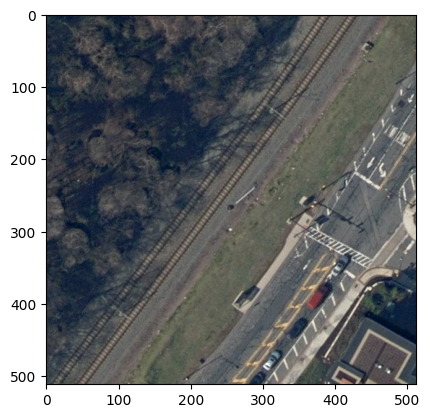

In [3]:
import random

from torch.utils import data


TRAIN_PERCENTAGE = 0.7
DATA_DIR = "data/manhattan"

dataset = AutoEncoderDataset(f"{DATA_DIR}/train")
testset = AutoEncoderDataset(f"{DATA_DIR}/test")
trainset, validationset = data.random_split(dataset, [TRAIN_PERCENTAGE, 1-TRAIN_PERCENTAGE])
random_index = random.randint(0, len(trainset)-1)
random_index = map_subset_indices_to_original_dataset_indices(trainset, [random_index])[0]
imshow(dataset.get_original_image(random_index))

In [4]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

## Queries
For each of the classes in the dataset, we are going to select one of the images in the test dataset and plot it. This images are the onew we are going to use to find similar images in the validation dataset.

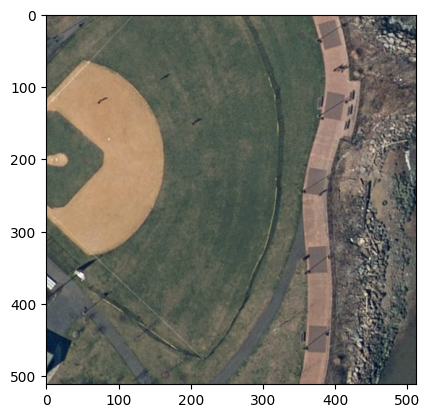

In [5]:
QUERY_1_IDX = 0
imshow(testset.get_original_image(QUERY_1_IDX))

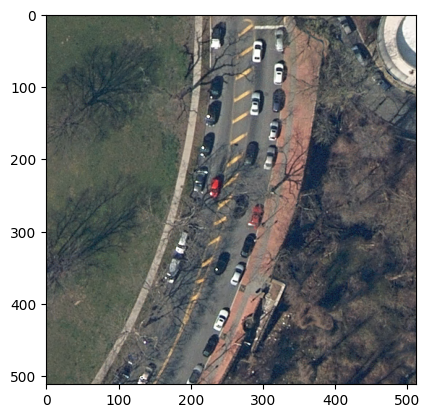

In [6]:
QUERY_2_IDX = 1
imshow(testset.get_original_image(QUERY_2_IDX))

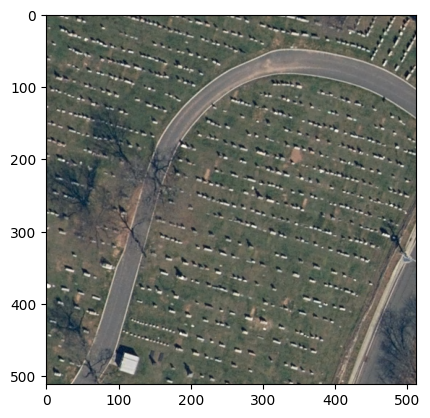

In [7]:
QUERY_3_IDX = 2
imshow(testset.get_original_image(QUERY_3_IDX))

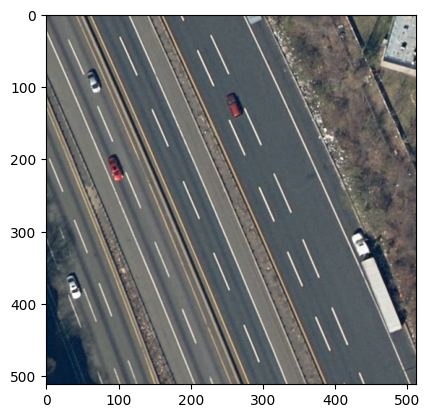

In [8]:
QUERY_4_IDX = 3
imshow(testset.get_original_image(QUERY_4_IDX))

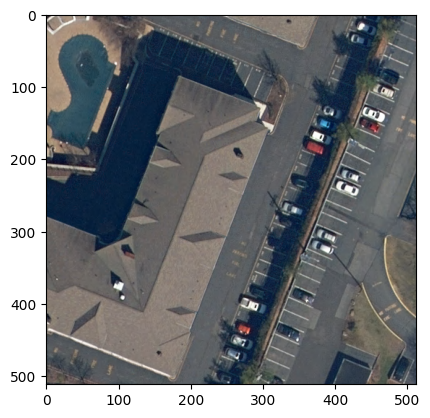

In [9]:
QUERY_5_IDX = 4
imshow(testset.get_original_image(QUERY_5_IDX))

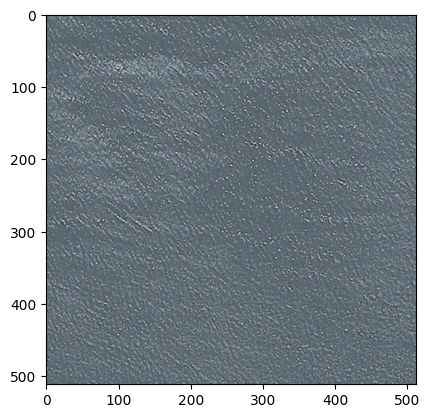

In [10]:
QUERY_6_IDX = 5
imshow(testset.get_original_image(QUERY_6_IDX))

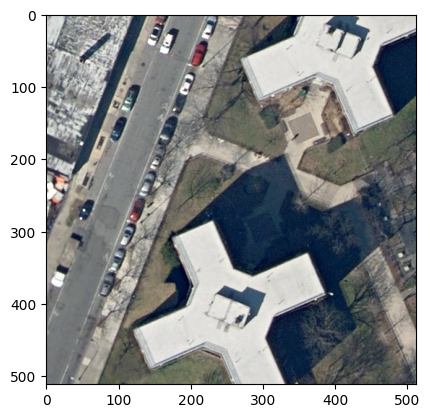

In [11]:
QUERY_7_IDX = 6
imshow(testset.get_original_image(QUERY_7_IDX))

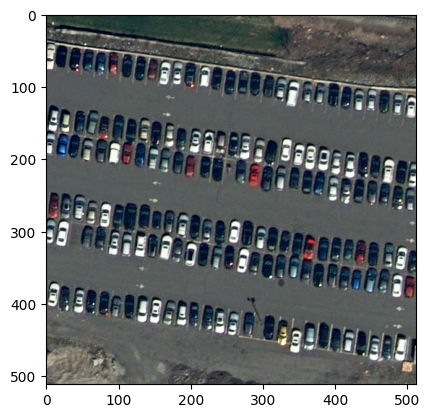

In [12]:
QUERY_8_IDX = 7
imshow(testset.get_original_image(QUERY_8_IDX))

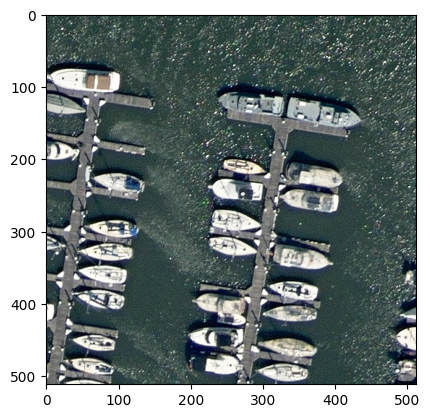

In [13]:
QUERY_9_IDX = 8
imshow(testset.get_original_image(QUERY_9_IDX))

We'll use GPU to speed things up

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading and predicting with pretrained encoder
To have a comparison point, we are going to load the ResNet-50 encoder and load the weights of the model trained with the ImageNet dataset, available in `torchvision`. We can observe the architecture of the whole Autoencoder.

The encoder will output and embedding of shape (2,048)

In [15]:
from torchvision.models.resnet import ResNet50_Weights


autoencoder = ResNetAutoEncoder(pretrained_weights=ResNet50_Weights.IMAGENET1K_V2)
autoencoder = autoencoder.to(device)

We are going to generate the embeddings of each of the images in the dataset. Then we are going to generate and store the embeddings of each image in the validation set. To make the queries, we are going to use the K-Nearest Neighbours algorithm to get the top 5 most similar validation images to each test image.

In [16]:
from sklearn.neighbors import NearestNeighbors


queries = []
autoencoder.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        queries.append(outputs[0].cpu())

image_embeddings = []
images = DataLoader(validationset, batch_size=1, shuffle=False, num_workers=2)
autoencoder.eval()
with torch.no_grad():
    for data in images:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        image_embeddings.append(outputs[0].cpu())
print(image_embeddings[0].shape)
print(image_embeddings[0])
neigh = NearestNeighbors(n_neighbors=5, algorithm="brute")
neigh.fit(image_embeddings)
distances, indices = neigh.kneighbors(queries)
print(indices)

torch.Size([2048])
tensor([0.0000, 0.0000, 0.0115,  ..., 0.0000, 0.0000, 0.0000])
[[ 97  95 123  12 132]
 [ 12 130  87  49   3]
 [ 90  28 132 110  45]
 [ 91   6  34  28 142]
 [136  25 102   8  96]
 [ 30  89 104  42  71]
 [ 46 144  18 135  49]
 [139  21  80   1  86]
 [ 15  20 109  23 110]]


## Pretrained weights result

Based on the title of the image, the resulting image is very accurate as all of them belong to the same class **AnnualCrop**

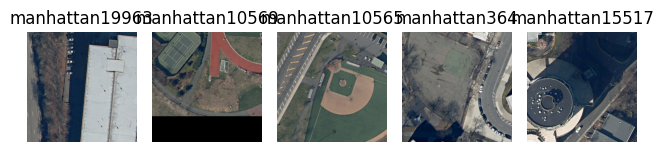

In [17]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_1_IDX]))

Although all te results belong to forests, which is the class of the query image, the similar images have a darker green than the original image.

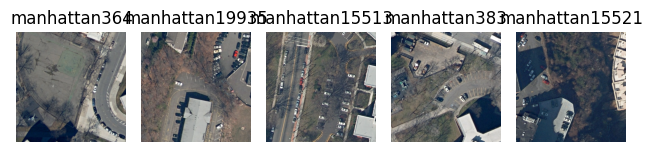

In [18]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_2_IDX]))

Something similar happend to the query of the **Herbaceous vegetation** colors and textures don't match.

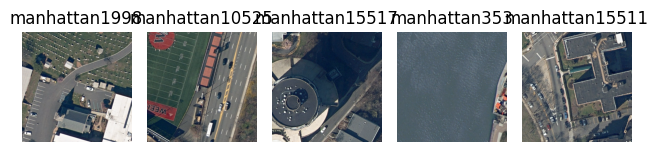

In [19]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_3_IDX]))

The similar images match the roads and the color of the dry land from the query image. Result three and five are very different.

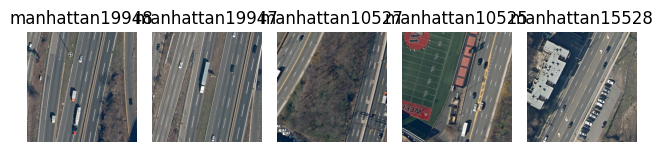

In [20]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_4_IDX]))

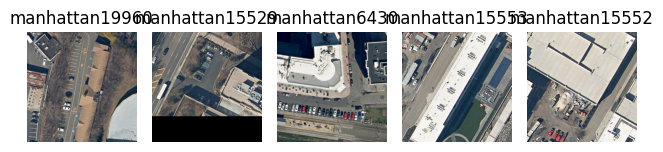

In [21]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_5_IDX]))

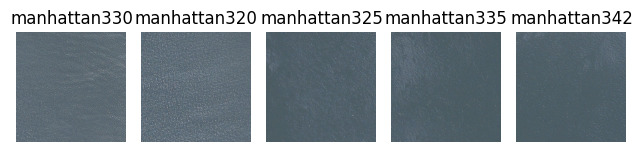

In [22]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_6_IDX]))

The query for **permanent crop** which was an image containing shapes with almost 90° angles, straight lines and clear borders gave better results. Although the results don't belong to the same class, visually the images are similar and have the same characteristics.

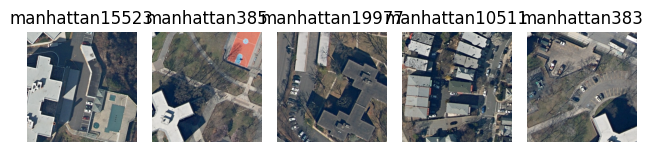

In [23]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_7_IDX]))

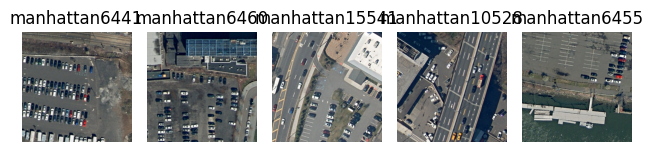

In [24]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_8_IDX]))

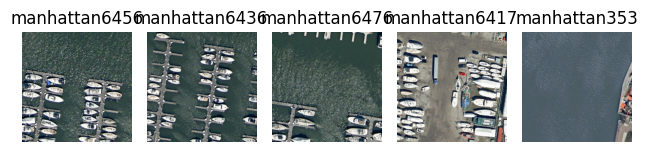

In [25]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_9_IDX]))

## Training the Autoencoder
We are going to start with the same model we used before to generate the embeddings: a ResNet-50 encoder pretrained with the ImageNet dataset.

In [43]:
from torchvision.models.resnet import ResNet50_Weights


autoencoder = ResNetAutoEncoder(pretrained_weights=ResNet50_Weights.IMAGENET1K_V2)
autoencoder = autoencoder.to(device)
train_loss = []
validation_loss = []
print(autoencoder)

ResNetAutoEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


To tune the model, Mean Squared Error (`NSELoss`) is going to be used to calculate the loss between the original input and the decoded image. There is some work left to do to train the model, but the following combination of hyperparameters have given good results.

During the first 10 epochs, there was a considerable decrease in the loss, the model began to learn very quickly, after that it continued learning, but at a lower pace.

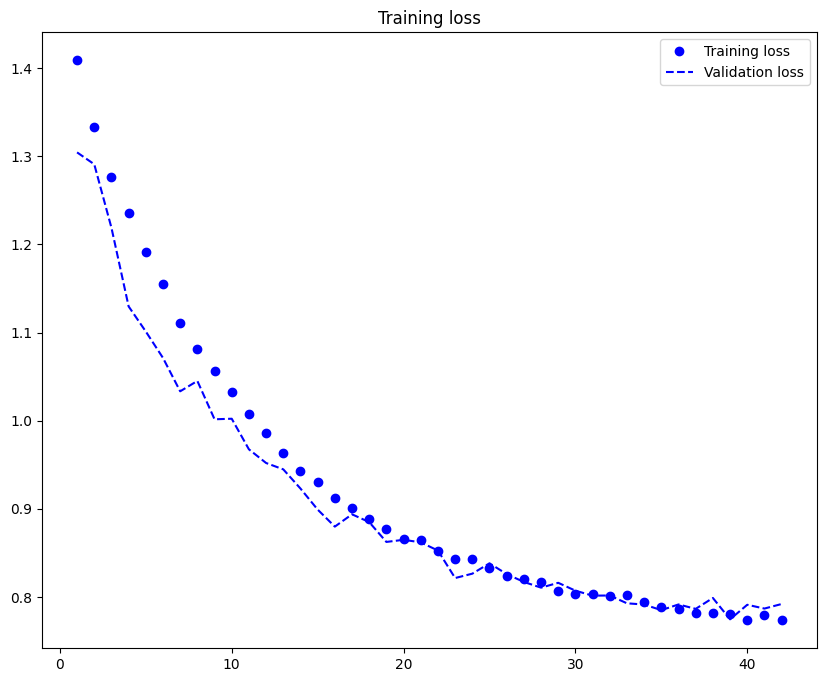

In [44]:
from torch.nn import MSELoss
from torch.optim import Adam


EPOCHS = 42
LEARNING_RATE = 0.0001

criterion = MSELoss()
for param in autoencoder.encoder.parameters():
    param.requires_grad_(False)
optimizer = Adam(autoencoder.decoder.parameters(), lr=LEARNING_RATE)
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    autoencoder.train()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images, False)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    val_loss = 0
    autoencoder.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = autoencoder(images, False)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(validation_loader)
    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    validation_loss.append(val_loss)
print_loss_history(train_loss, validation_loss)

In [45]:
train_loss = []
validation_loss = []

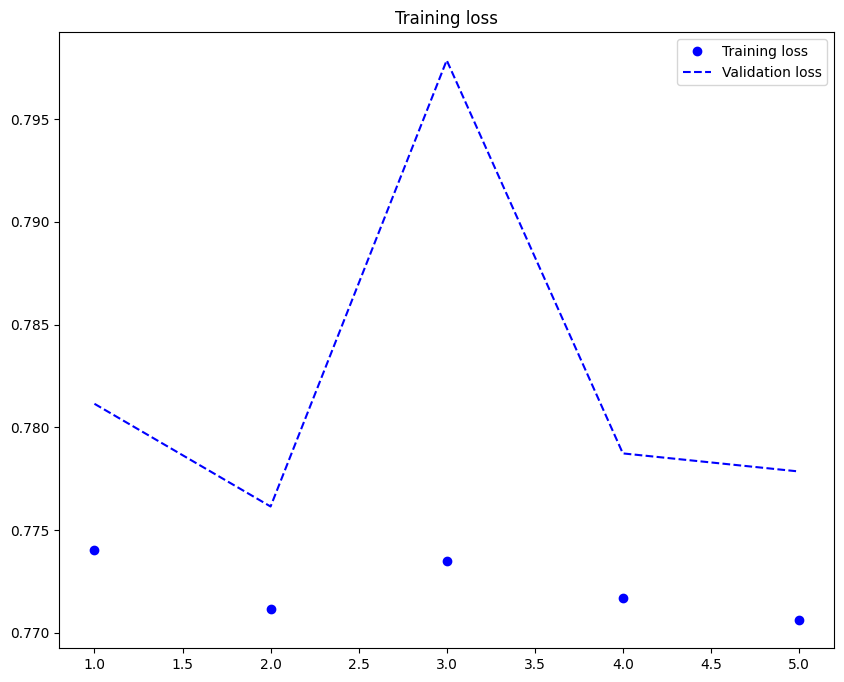

In [46]:
from torch.nn import MSELoss
from torch.optim import Adam


EPOCHS = 5
LEARNING_RATE = 0.000001

criterion = MSELoss()
for param in autoencoder.encoder.parameters():
    param.requires_grad_(True)
optimizer = Adam(autoencoder.parameters(), lr=LEARNING_RATE)
for epoch in range(1, EPOCHS + 1):
    running_loss = 0
    autoencoder.train()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images, False)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    val_loss = 0
    autoencoder.eval()
    with torch.no_grad():
        for i, data in enumerate(validation_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = autoencoder(images, False)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss = val_loss / len(validation_loader)
    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    validation_loss.append(val_loss)
print_loss_history(train_loss, validation_loss)

To visually see the performance of the decoder, an image from the validation set will be plotted. This image contains clear borders, shapes and different sections with the same colour.

In [63]:
SAMPLE_IMAGE_IDX = 4

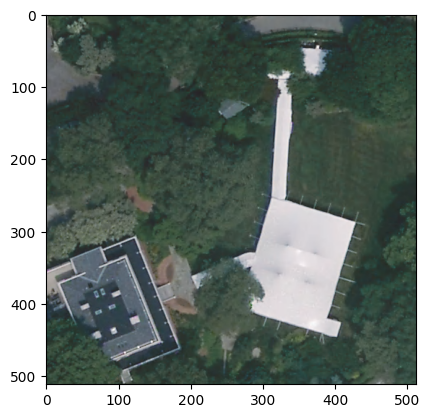

In [64]:
imshow(dataset.get_original_image(trainset.indices[SAMPLE_IMAGE_IDX]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


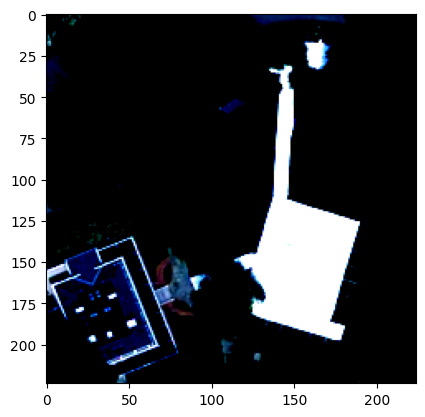

In [65]:
imshow(trainset[SAMPLE_IMAGE_IDX][0])

The output is very different than the input, the decoder hasn't been able to learn how to decode the image correctly.

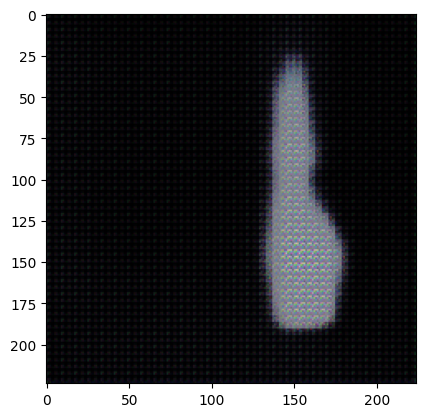

In [66]:
autoencoder.eval()
with torch.no_grad():
    validation_image, _ = trainset[SAMPLE_IMAGE_IDX]
    validation_image = validation_image.unsqueeze(0)
    validation_image = validation_image.to(device)
    outputs = autoencoder(validation_image, False)[0]
imshow(outputs.cpu())

Compute again the embeddings for the images in the *validation* and *test* set. Then, use *K-Nearest Neighbours* to find the most similar images to each query image.

In [33]:
from sklearn.neighbors import NearestNeighbors


queries = []
autoencoder.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        queries.append(outputs[0].cpu())

image_embeddings = []
images = DataLoader(validationset, batch_size=1, shuffle=False, num_workers=2)
autoencoder.eval()
with torch.no_grad():
    for data in images:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = autoencoder(images)
        image_embeddings.append(outputs[0].cpu())
print(image_embeddings[0].shape)
print(image_embeddings[0])
neigh = NearestNeighbors(n_neighbors=5, algorithm="brute")
neigh.fit(image_embeddings)
distances, indices = neigh.kneighbors(queries)
print(indices)

torch.Size([2048])
tensor([0.2845, 0.0297, 0.0943,  ..., 0.0024, 0.0000, 0.0000])
[[ 15  43  40  14   3]
 [  1  51   3  57 143]
 [ 15 104  93  42  74]
 [  1   6  81 102  15]
 [  1  70 112  57 102]
 [ 30  89  93  42 104]
 [  1  70  15   3  81]
 [139  36   1  15  21]
 [ 15  20   1  93  23]]


The first query gave results that have similar colours, textures and shapes than the query image.

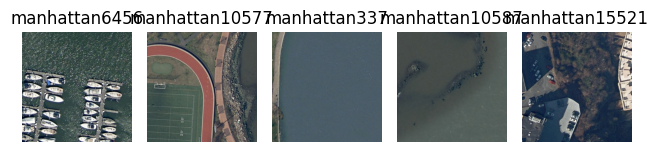

In [67]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_1_IDX]))

The second query also have images with the same textures and colours than in the query. You can see trees and its shadows in the similar images.

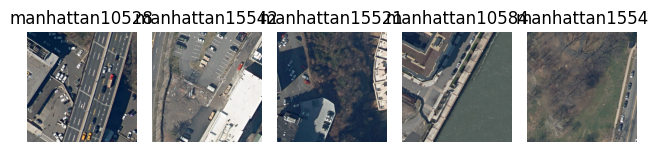

In [68]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_2_IDX]))

Similar to the previous queries, the results have similar colours and textures than the query image.

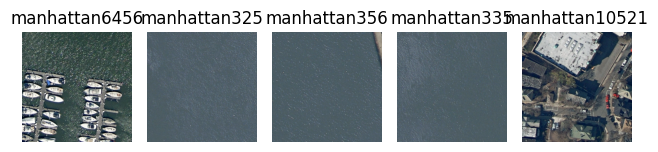

In [69]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_3_IDX]))

For the query of the highways, the model had problems identifying the roads in the similar images, it returned images with the same colours and texture of the dry land that can be seen in the query image.

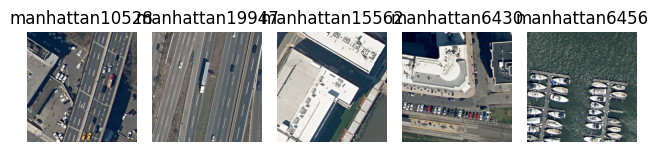

In [70]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_4_IDX]))

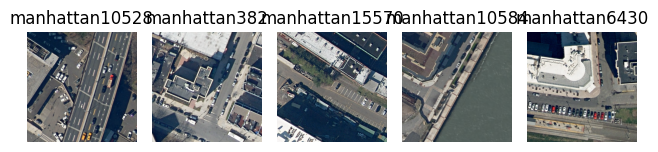

In [71]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_5_IDX]))

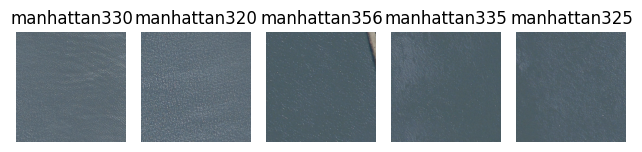

In [72]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_6_IDX]))

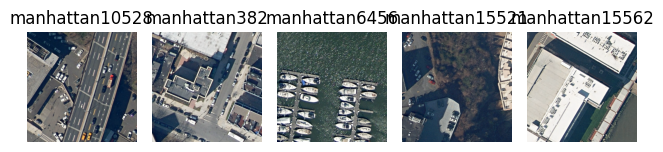

In [73]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_7_IDX]))

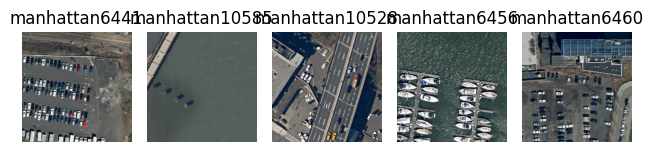

In [74]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_8_IDX]))

The query of the river has dark blue water, several buildings and well defined borders between the water and the land. In this case, the results contain images that have buildings and borders. The model might have confused the dark blue colour of the water with the dark green of the trees in the results.

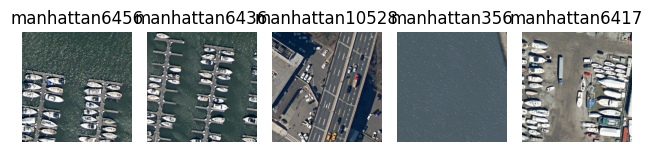

In [75]:
plot_images(dataset, map_subset_indices_to_original_dataset_indices(validationset, indices[QUERY_9_IDX]))

### Conclusions
By training the autoencoder, the generation of the embeddings to make the similarity search improved. In some cases, the results of the similarity search with the trained model improved and are visually more similar to the images than without training, but in other cases, the results get worse. For future work other techniques should be used to improve the training of the model